In [33]:
from pathways.scenarios import run_scenarios, load_scenario_table
from pathways.simulation import load_configuration
from pathways.outputs import save_scenario_result_to_pandas

In [34]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [115]:
from pathlib import Path
datadir = Path("tests/test_summaries")
basic_config = load_configuration(datadir / "config.yml")
scenario_table = load_scenario_table(datadir / "validation_scenarios.csv")

In [116]:
sample_validation_scenarios = scenario_table[0:16]
infest_validation_scenarios = scenario_table[16:32]
outcome_validation_scenarios = scenario_table[32:34]

In [117]:
num_shipments = 1
sample_validation_results, sample_validation_details = run_scenarios(
    config=basic_config,
    scenario_table=sample_validation_scenarios,
    seed=42,
    num_simulations=1,
    num_shipments=num_shipments,
    detailed=True,
)

sample_validation_1
sample_validation_2
sample_validation_3
sample_validation_4
sample_validation_5
sample_validation_6
sample_validation_7
sample_validation_8
sample_validation_9
sample_validation_10
sample_validation_11
sample_validation_12
sample_validation_13
sample_validation_14
sample_validation_15
sample_validation_16


In [118]:
sample_validation_df = save_scenario_result_to_pandas(
    sample_validation_results,
    config_columns=[
        "name",
        "shipment_name",
        "inspection_name",
        "shipment/boxes/min",
        "shipment/boxes/max",
        "shipment/stems_per_box/default",
        "inspection/unit",
        "inspection/sample_strategy",
        "inspection/proportion/value",
        "inspection/hypergeometric/detection_level",
        "inspection/selection_strategy",
    ],
    result_columns=[
        "avg_boxes_opened_completion",
        "avg_stems_inspected_completion",
    ],
)
sample_validation_df

,name,shipment_name,inspection_name,shipment/boxes/min,shipment/boxes/max,shipment/stems_per_box/default,inspection/unit,inspection/sample_strategy,inspection/proportion/value,inspection/hypergeometric/detection_level,inspection/selection_strategy,avg_boxes_opened_completion,avg_stems_inspected_completion
0,sample_validation_1,clustered_10,stem_hypergeometric_random,10,10,50,stems,hypergeometric,,0.01,random,10.0,225.0
1,sample_validation_2,clustered_10,stem_hypergeometric_tailgate,10,10,50,stems,hypergeometric,,0.01,tailgate,5.0,225.0
2,sample_validation_3,clustered_10,stem_proportion_random,10,10,50,stems,proportion,0.02,,random,7.0,10.0
3,sample_validation_4,clustered_10,stem_proportion_tailgate,10,10,50,stems,proportion,0.02,,tailgate,1.0,10.0
4,sample_validation_5,clustered_10,box_hypergeometric_random,10,10,50,boxes,hypergeometric,,0.01,random,10.0,500.0
5,sample_validation_6,clustered_10,box_hypergeometric_tailgate,10,10,50,boxes,hypergeometric,,0.01,tailgate,10.0,500.0
6,sample_validation_7,clustered_10,box_proportion_random,10,10,50,boxes,proportion,0.02,,random,0.0,0.0
7,sample_validation_8,clustered_10,box_proportion_tailgate,10,10,50,boxes,proportion,0.02,,tailgate,0.0,0.0
8,sample_validation_9,clustered_100,stem_hypergeometric_random,100,100,50,stems,hypergeometric,,0.01,random,92.0,290.0
9,sample_validation_10,clustered_100,stem_hypergeometric_tailgate,100,100,50,stems,hypergeometric,,0.01,tailgate,6.0,290.0


In [119]:
sample_validation_stems = [i[0] for i in sample_validation_details]
sample_validation_inspected_indexes = [i[1] for i in sample_validation_details]

In [120]:
sample_validation_inspected_indexes[0][0]

[0,
 1,
 3,
 5,
 9,
 13,
 15,
 16,
 22,
 23,
 24,
 28,
 29,
 32,
 33,
 35,
 36,
 40,
 43,
 44,
 46,
 47,
 49,
 51,
 52,
 54,
 56,
 57,
 58,
 61,
 63,
 64,
 65,
 70,
 71,
 73,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 87,
 91,
 98,
 101,
 102,
 107,
 108,
 110,
 111,
 112,
 114,
 115,
 116,
 117,
 119,
 122,
 123,
 125,
 126,
 128,
 134,
 135,
 136,
 137,
 138,
 142,
 148,
 150,
 152,
 157,
 159,
 161,
 165,
 166,
 172,
 174,
 176,
 181,
 183,
 185,
 186,
 189,
 191,
 193,
 194,
 195,
 197,
 202,
 204,
 205,
 214,
 216,
 219,
 222,
 224,
 229,
 231,
 232,
 234,
 235,
 236,
 239,
 243,
 248,
 250,
 252,
 255,
 256,
 258,
 259,
 260,
 264,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 279,
 281,
 282,
 283,
 285,
 287,
 290,
 295,
 298,
 299,
 301,
 302,
 305,
 306,
 308,
 309,
 311,
 313,
 315,
 316,
 320,
 321,
 323,
 325,
 327,
 328,
 329,
 331,
 332,
 335,
 338,
 341,
 343,
 346,
 347,
 348,
 349,
 350,
 352,
 357,
 359,
 360,
 361,
 365,
 366,
 367,
 368,
 370,
 373,
 377,
 379,
 380,
 381,
 

In [121]:
sample_validation_inspected_indexes[1][0]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [122]:
sample_validation_inspected_indexes[2][0]

[44, 52, 71, 114, 125, 279, 346, 377, 379, 456]

In [123]:
sample_validation_inspected_indexes[3][0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [124]:
num_shipments = 10
infest_validation_results, infest_validation_details = run_scenarios(
    config=basic_config,
    scenario_table=infest_validation_scenarios,
    seed=42,
    num_simulations=1,
    num_shipments=num_shipments,
    detailed=True,
)

infest_validation_1
infest_validation_2
infest_validation_3
infest_validation_4
infest_validation_5
infest_validation_6
infest_validation_7
infest_validation_8
infest_validation_9
infest_validation_10
infest_validation_11
infest_validation_12
infest_validation_13
infest_validation_14
infest_validation_15
infest_validation_16


In [125]:
infest_validation_df = save_scenario_result_to_pandas(
    infest_validation_results,
    config_columns=[
        "name",
        "shipment_name",
        "shipment/boxes/min",
        "shipment/boxes/max",
        "shipment/stems_per_box/default",
        "pest/infestation_unit",
        "pest/infestation_rate/distribution",
        "pest/infestation_rate/value",
        "pest/infestation_rate/parameters",
        "pest/arrangement",
        "pest/clustered/distribution",
        "pest/clustered/max_infested_units_per_cluster",
        "pest/clustered/random/max_cluster_stem_width",
    ],
    result_columns=[
        "true_infestation_rate",
        "max_missed_infestation_rate",
        "avg_missed_infestation_rate",
        "max_intercepted_infestation_rate",
        "avg_intercepted_infestation_rate",
    ],
)
infest_validation_df

,name,shipment_name,shipment/boxes/min,shipment/boxes/max,shipment/stems_per_box/default,pest/infestation_unit,pest/infestation_rate/distribution,pest/infestation_rate/value,pest/infestation_rate/parameters,pest/arrangement,pest/clustered/distribution,pest/clustered/max_infested_units_per_cluster,pest/clustered/random/max_cluster_stem_width,true_infestation_rate,max_missed_infestation_rate,avg_missed_infestation_rate,max_intercepted_infestation_rate,avg_intercepted_infestation_rate
0,infest_validation_1,clustered_stem_0.01,20,20,200,stem,fixed_value,0.01,,clustered,random,200,400,0.01,0.01,0.01,None,None
1,infest_validation_2,random_stem_0.01,20,20,200,stem,fixed_value,0.01,,random,,,400,0.01,0.01,0.01,None,None
2,infest_validation_3,clustered_box_0.01,20,20,200,box,fixed_value,0.01,,clustered,random,2,400,0.00,NaN,NaN,None,None
3,infest_validation_4,random_box_0.01,20,20,200,box,fixed_value,0.01,,random,,,400,0.00,NaN,NaN,None,None
4,infest_validation_5,clustered_stem_0.1,20,20,200,stem,fixed_value,0.10,,clustered,random,200,400,0.10,0.10,0.10,None,None
5,infest_validation_6,random_stem_0.1,20,20,200,stem,fixed_value,0.10,,random,,,400,0.10,0.10,0.10,None,None
6,infest_validation_7,clustered_box_0.1,20,20,200,box,fixed_value,0.10,,clustered,random,2,400,0.10,0.10,0.10,None,None
7,infest_validation_8,random_box_0.1,20,20,200,box,fixed_value,0.10,,random,,,400,0.10,0.10,0.10,None,None
8,infest_validation_9,clustered_stem_0.2,20,20,200,stem,fixed_value,0.20,,clustered,random,200,400,0.20,0.20,0.20,None,None
9,infest_validation_10,random_stem_0.2,20,20,200,stem,fixed_value,0.20,,random,,,400,0.20,0.20,0.20,None,None


In [126]:
infest_validation_stems = [i[0] for i in infest_validation_details]
infest_validation_inspected_indexes = [i[1] for i in infest_validation_details]

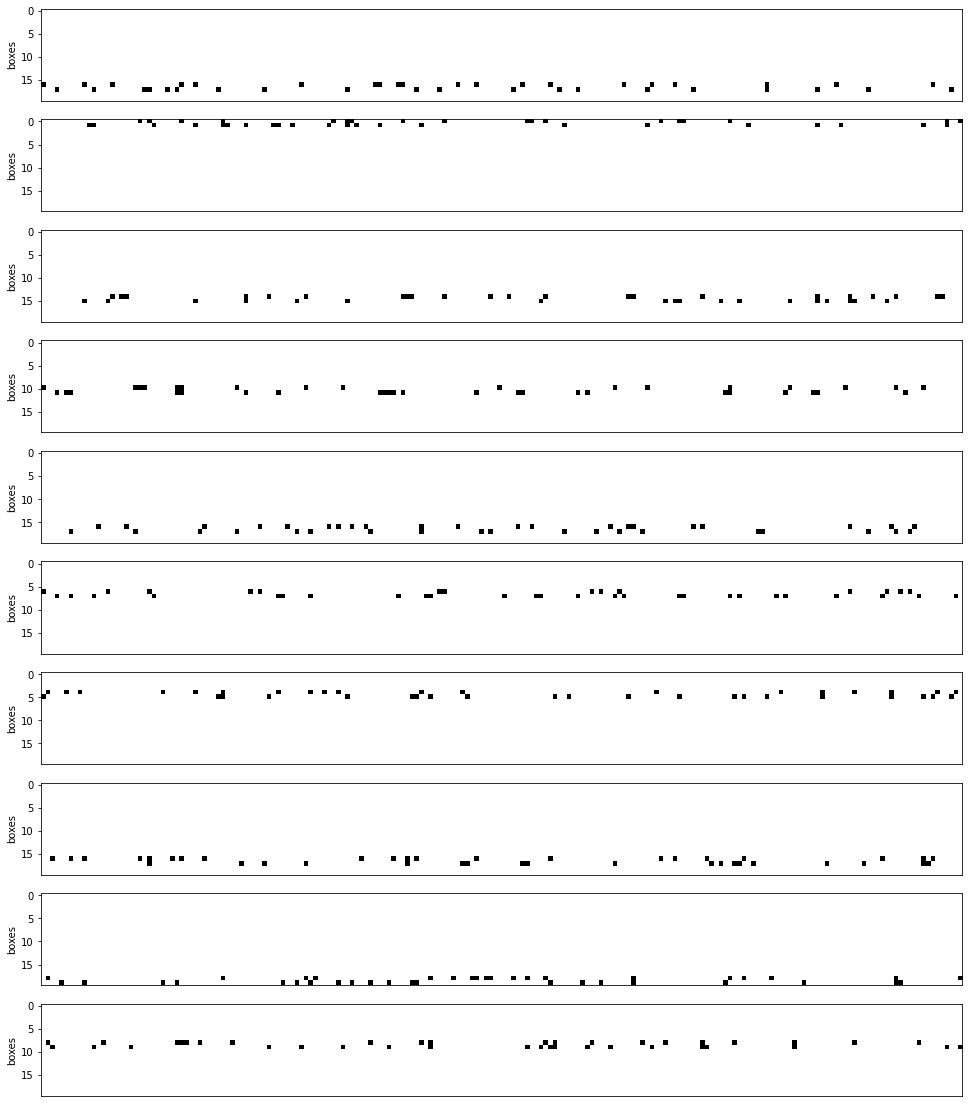

In [127]:
infest_validation_stems_1 = np.stack(infest_validation_stems[0])
stems_by_shipment = np.vsplit(infest_validation_stems_1, num_shipments)

fig, axs = plt.subplots(len(stems_by_shipment), figsize=(25,20))

for i in range(len(stems_by_shipment)):
    axs[i].matshow(stems_by_shipment[i], cmap='Greys')
    axs[i].set_ylabel('boxes')
    axs[i].tick_params(labeltop=False, top=False, bottom=False)

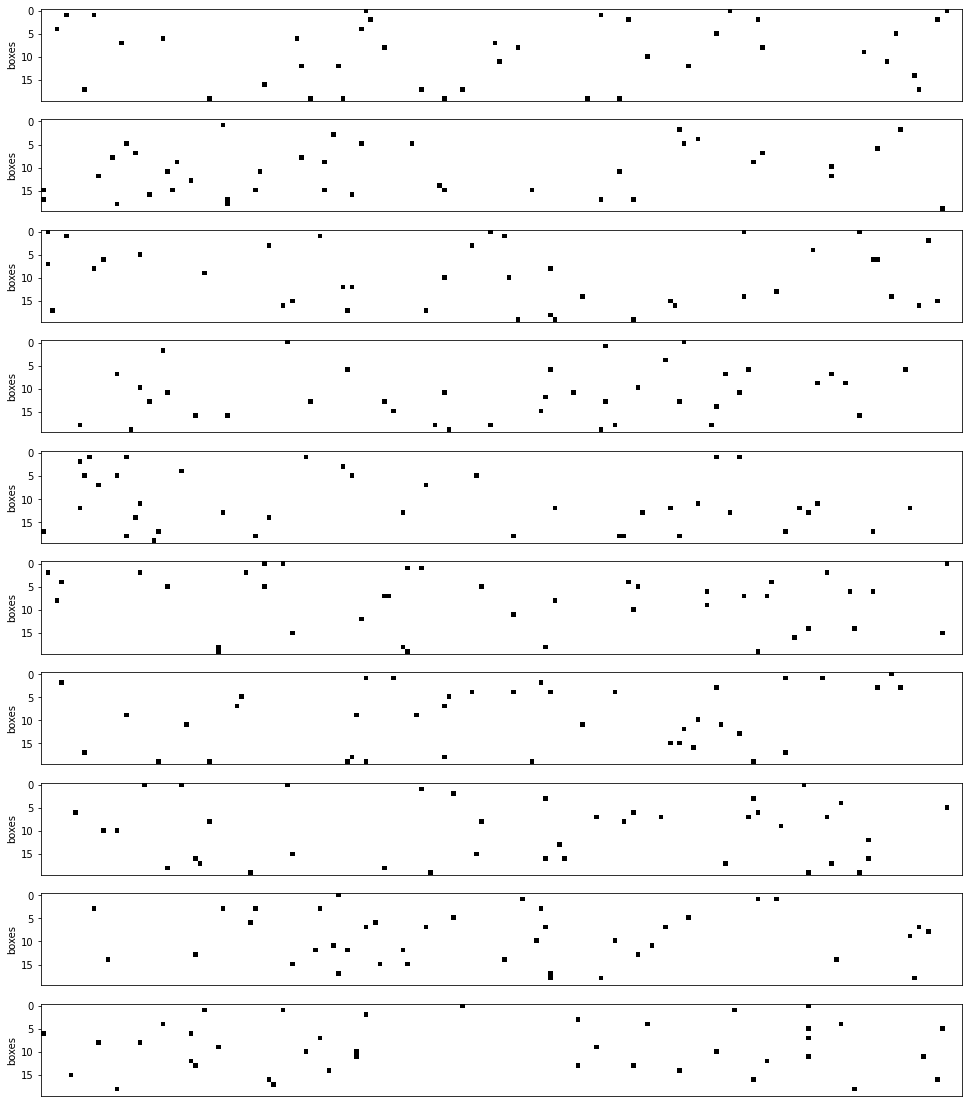

In [128]:
infest_validation_stems_2 = np.stack(infest_validation_stems[1])
stems_by_shipment = np.vsplit(infest_validation_stems_2, num_shipments)

fig, axs = plt.subplots(len(stems_by_shipment), figsize=(25,20))

for i in range(len(stems_by_shipment)):
    axs[i].matshow(stems_by_shipment[i], cmap='Greys')
    axs[i].set_ylabel('boxes')
    axs[i].tick_params(labeltop=False, top=False, bottom=False)

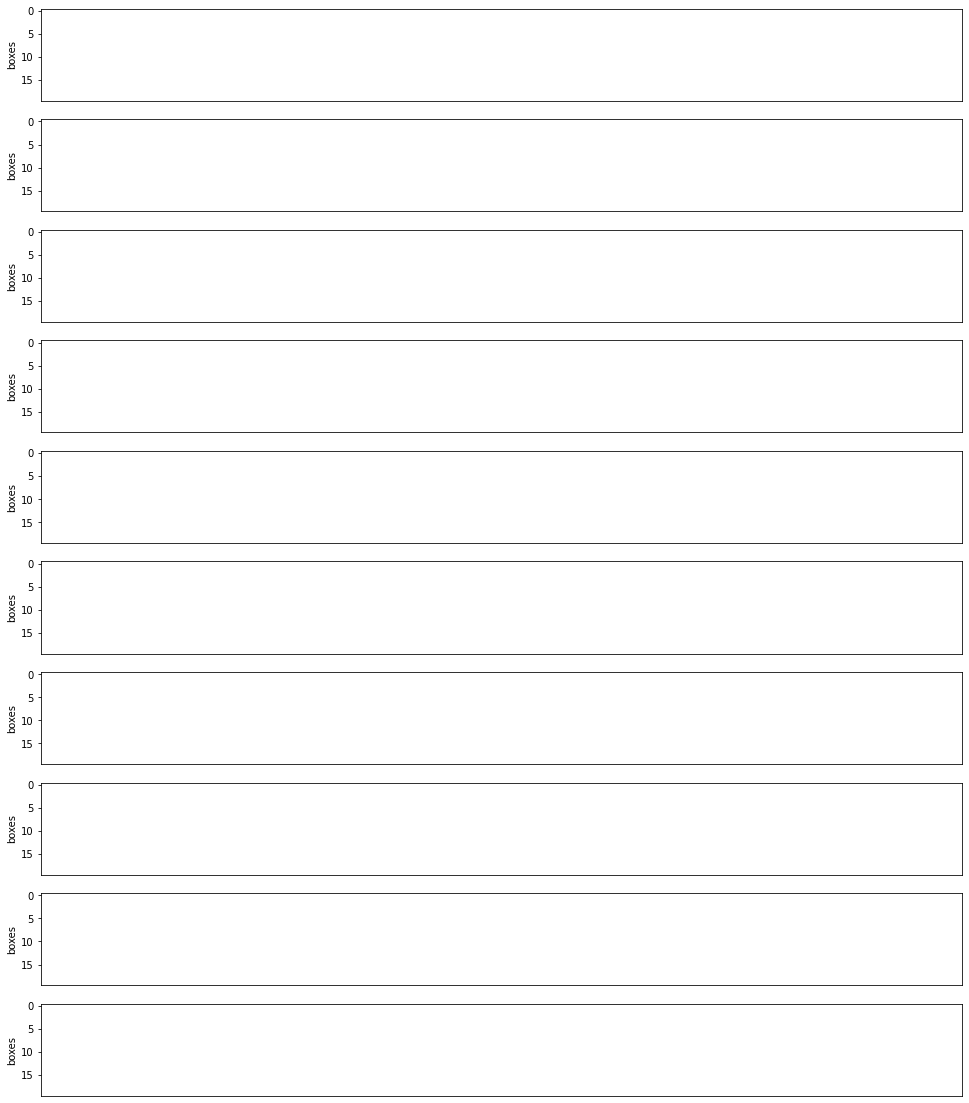

In [129]:
infest_validation_stems_3 = np.stack(infest_validation_stems[2])
stems_by_shipment = np.vsplit(infest_validation_stems_3, num_shipments)

fig, axs = plt.subplots(len(stems_by_shipment), figsize=(25,20))

for i in range(len(stems_by_shipment)):
    axs[i].matshow(stems_by_shipment[i], cmap='Greys')
    axs[i].set_ylabel('boxes')
    axs[i].tick_params(labeltop=False, top=False, bottom=False)

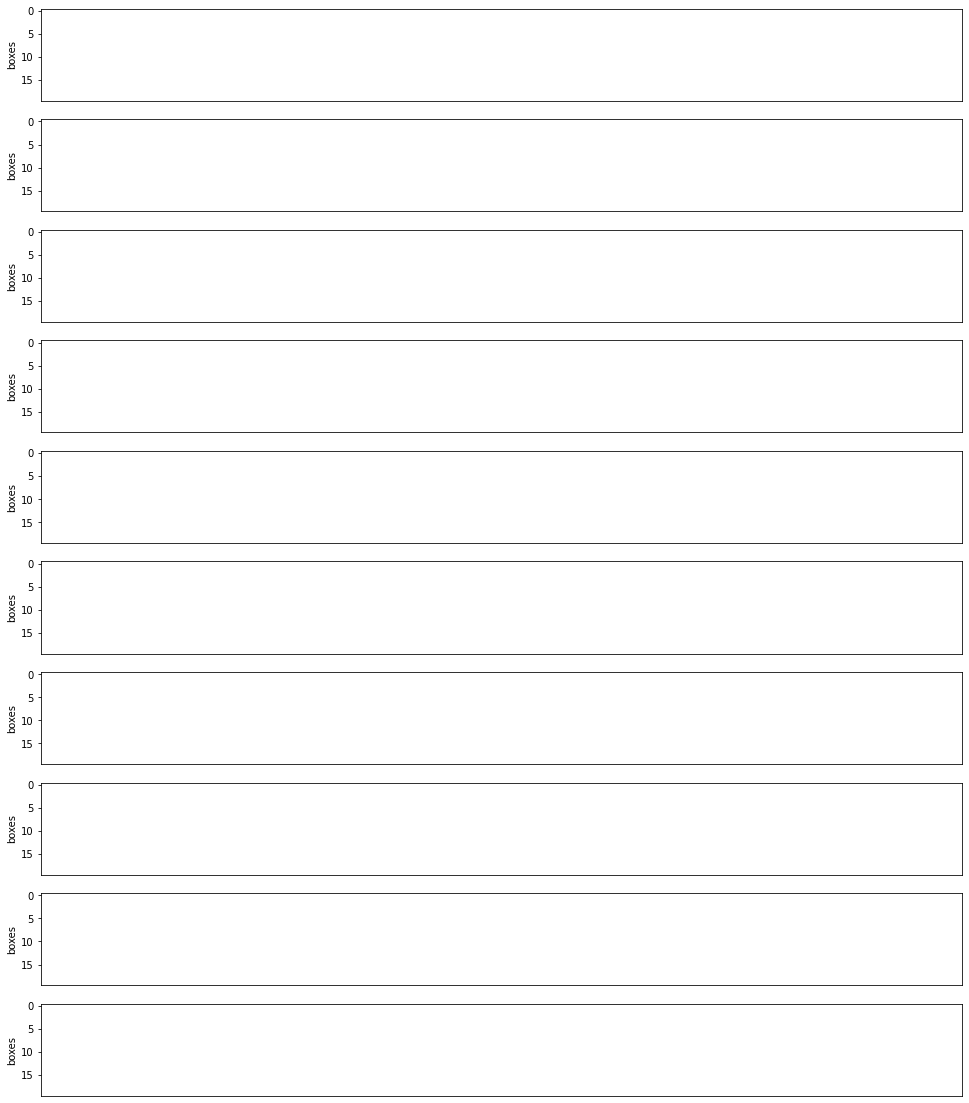

In [130]:
infest_validation_stems_4 = np.stack(infest_validation_stems[3])
stems_by_shipment = np.vsplit(infest_validation_stems_4, num_shipments)

fig, axs = plt.subplots(len(stems_by_shipment), figsize=(25,20))

for i in range(len(stems_by_shipment)):
    axs[i].matshow(stems_by_shipment[i], cmap='Greys')
    axs[i].set_ylabel('boxes')
    axs[i].tick_params(labeltop=False, top=False, bottom=False)

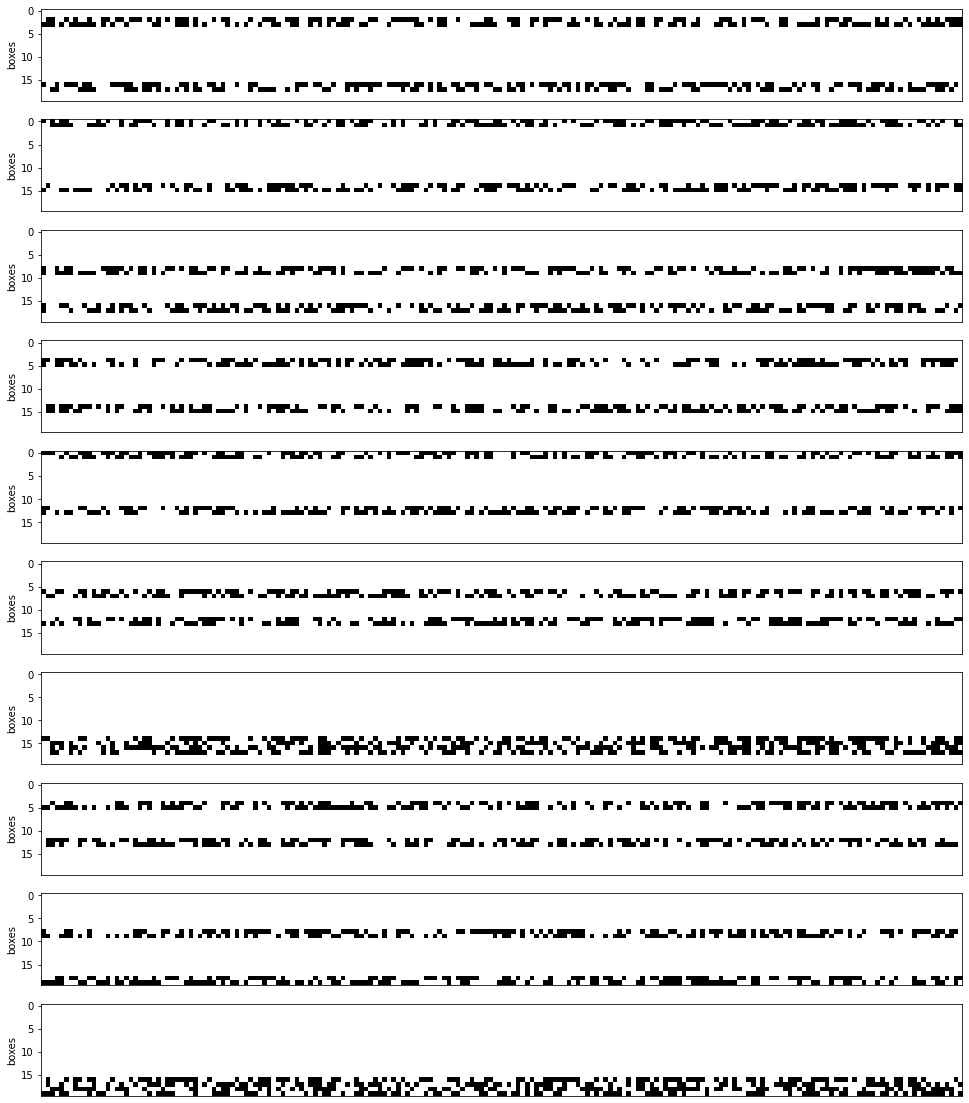

In [131]:
infest_validation_stems_5 = np.stack(infest_validation_stems[4])
stems_by_shipment = np.vsplit(infest_validation_stems_5, num_shipments)

fig, axs = plt.subplots(len(stems_by_shipment), figsize=(25,20))

for i in range(len(stems_by_shipment)):
    axs[i].matshow(stems_by_shipment[i], cmap='Greys')
    axs[i].set_ylabel('boxes')
    axs[i].tick_params(labeltop=False, top=False, bottom=False)

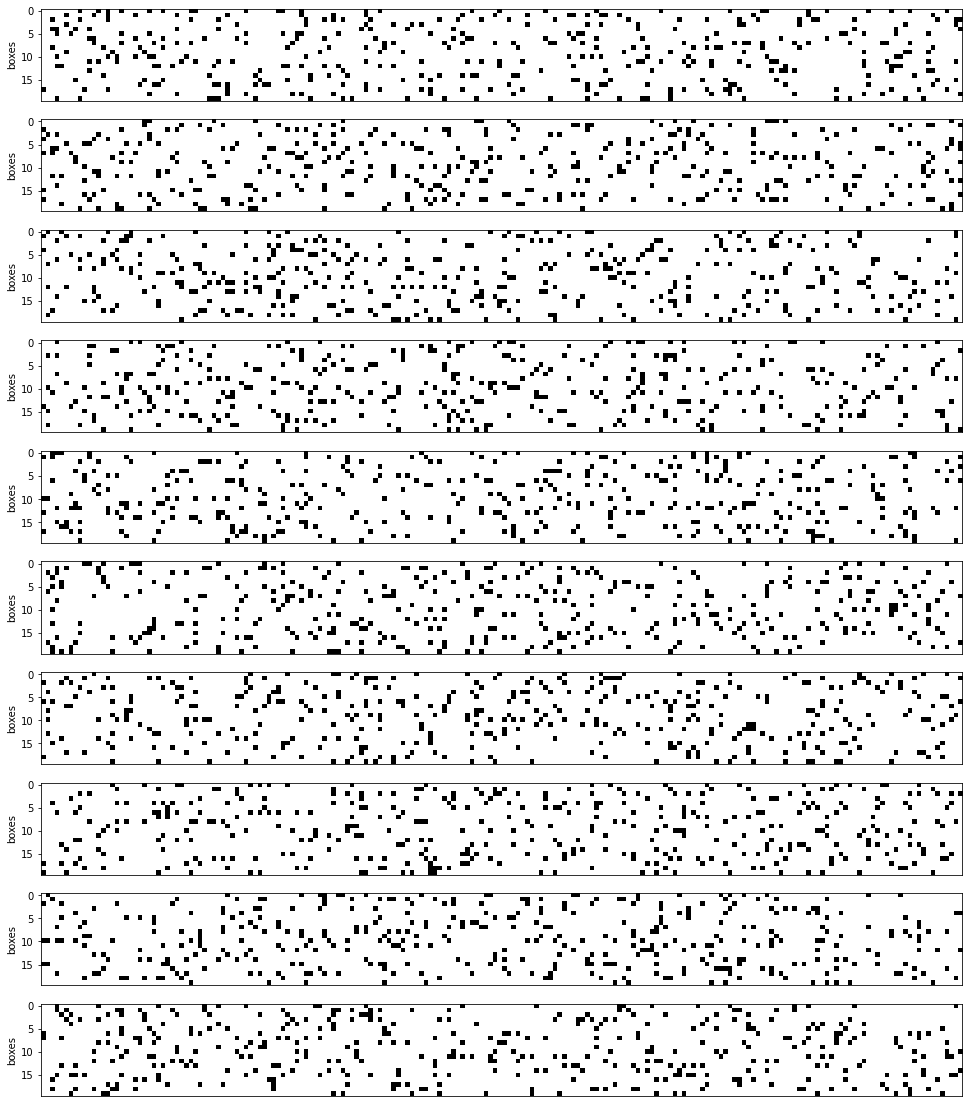

In [132]:
infest_validation_stems_6 = np.stack(infest_validation_stems[5])
stems_by_shipment = np.vsplit(infest_validation_stems_6, num_shipments)

fig, axs = plt.subplots(len(stems_by_shipment), figsize=(25,20))

for i in range(len(stems_by_shipment)):
    axs[i].matshow(stems_by_shipment[i], cmap='Greys')
    axs[i].set_ylabel('boxes')
    axs[i].tick_params(labeltop=False, top=False, bottom=False)

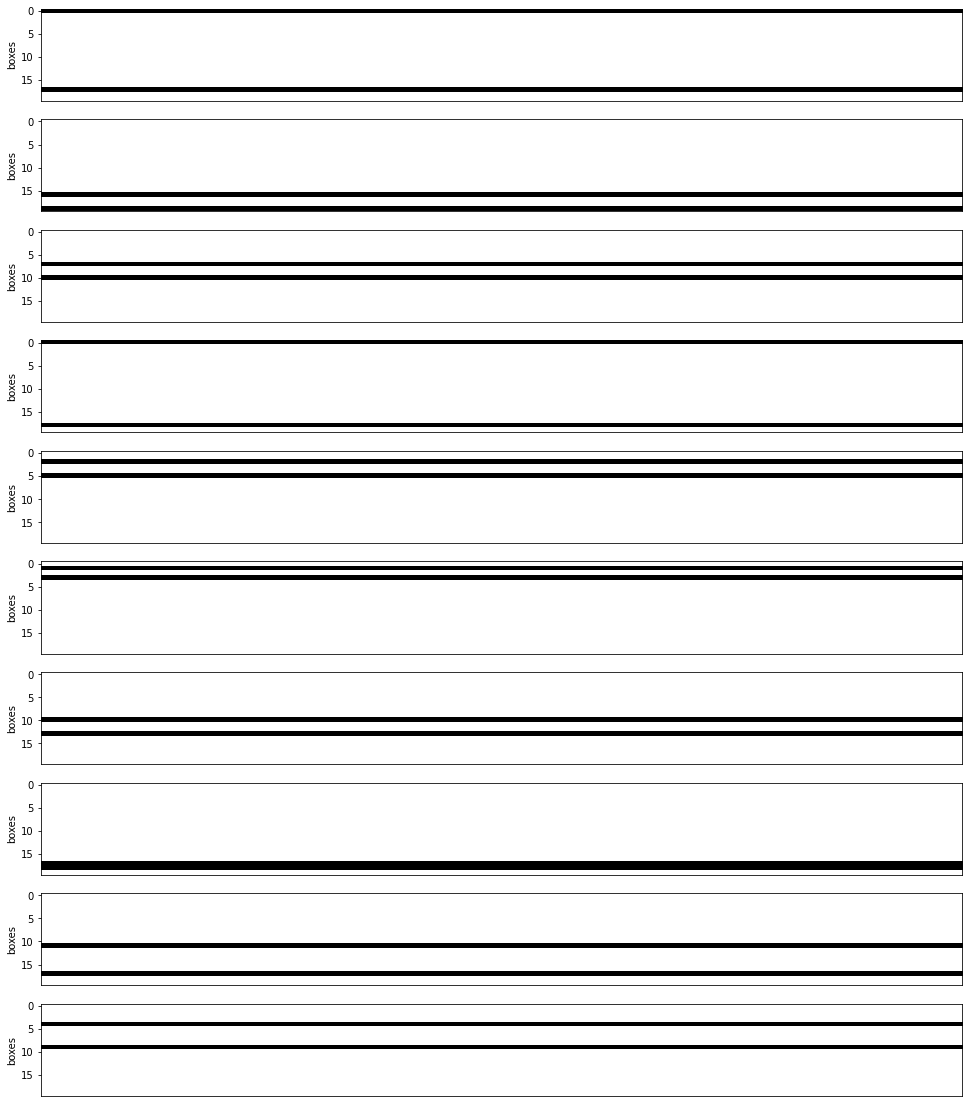

In [133]:
infest_validation_stems_7 = np.stack(infest_validation_stems[6])
stems_by_shipment = np.vsplit(infest_validation_stems_7, num_shipments)

fig, axs = plt.subplots(len(stems_by_shipment), figsize=(25,20))

for i in range(len(stems_by_shipment)):
    axs[i].matshow(stems_by_shipment[i], cmap='Greys')
    axs[i].set_ylabel('boxes')
    axs[i].tick_params(labeltop=False, top=False, bottom=False)

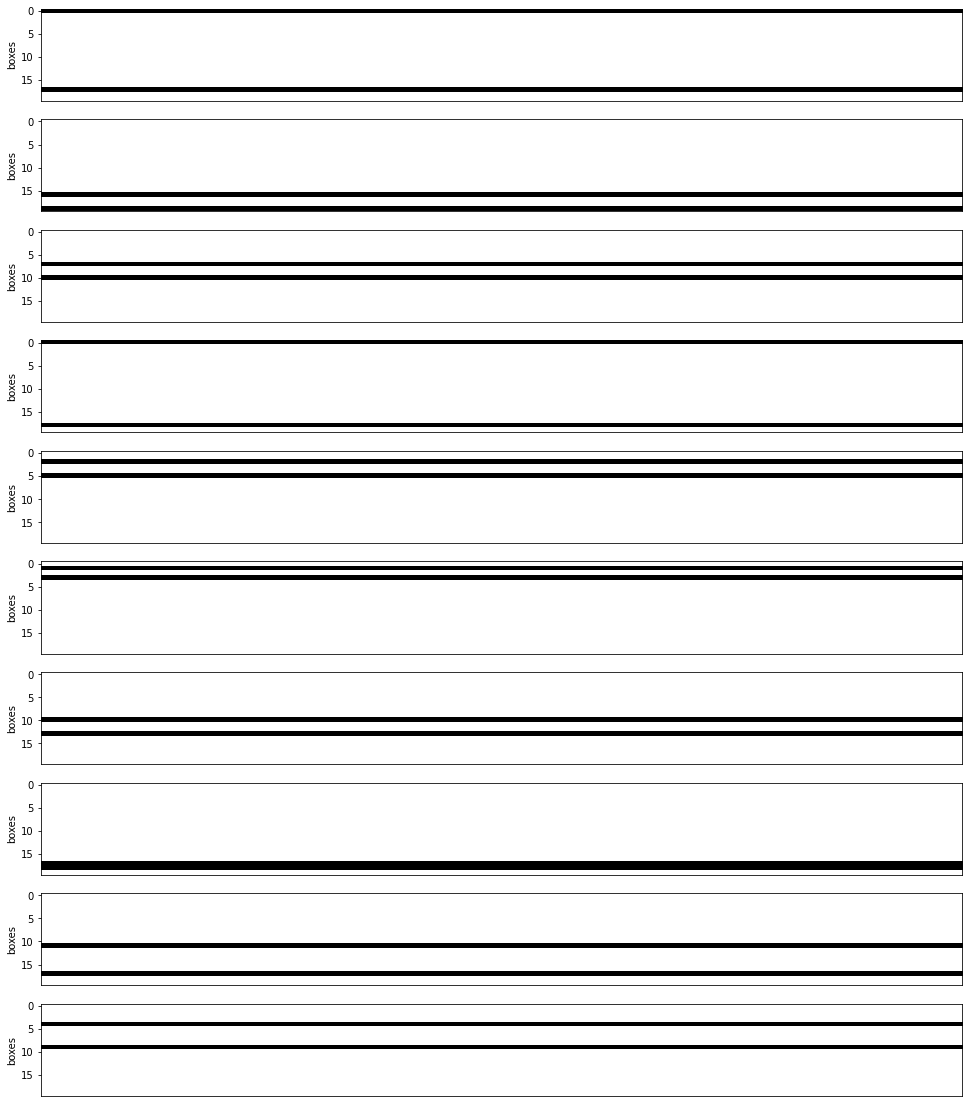

In [134]:
infest_validation_stems_8 = np.stack(infest_validation_stems[7])
stems_by_shipment = np.vsplit(infest_validation_stems_8, num_shipments)

fig, axs = plt.subplots(len(stems_by_shipment), figsize=(25,20))

for i in range(len(stems_by_shipment)):
    axs[i].matshow(stems_by_shipment[i], cmap='Greys')
    axs[i].set_ylabel('boxes')
    axs[i].tick_params(labeltop=False, top=False, bottom=False)

In [ ]:
num_shipments = 1000
outcome_validation_results, outcome_validation_details = run_scenarios(
    config=basic_config,
    scenario_table=outcome_validation_scenarios,
    seed=42,
    num_simulations=1,
    num_shipments=num_shipments,
)

In [ ]:
outcome_validation_df = save_scenario_result_to_pandas(
    outcome_validation_results,
    config_columns=[
        "name",
        "shipment_name",
        "inspection_name",
        "shipment/boxes/min",
        "shipment/boxes/max",
        "shipment/stems_per_box/default",
        "pest/infestation_unit",
        "pest/infestation_rate/distribution",
        "pest/infestation_rate/value",
        "pest/infestation_rate/parameters",
        "pest/arrangement",
        "pest/clustered/distribution",
        "pest/clustered/max_infested_units_per_cluster",
        "pest/clustered/random/max_cluster_stem_width",
    ],
    result_columns=[
        "true_infestation_rate",
        "max_missed_infestation_rate",
        "avg_missed_infestation_rate",
        "max_intercepted_infestation_rate",
        "avg_intercepted_infestation_rate",
    ],
)
outcome_validation_df

In [ ]:
df['shipment_name'] = pd.Categorical(df['shipment_name'])
shipment_order = ["infestation_5", "infestation_10", "infestation_25", "small", "large", "maritime", "clustered", "clustered_small", "clustered_large"]
df['shipment_name'] = df['shipment_name'].cat.reorder_categories(shipment_order, ordered=True)
df

In [ ]:
df.plot(kind="bar", x="inspection_name", y="missing")

In [ ]:
#df["shipment"] = df.apply(lambda row: re.sub("_[0-9]+$", "", row["name"]), axis = 1)

In [ ]:
df.groupby("shipment_name").agg({"missing": "mean"}).reset_index().plot(kind="bar", x="shipment_name", y="missing")

In [ ]:
df.groupby("inspection_name").agg({"missing": "mean"}).reset_index().plot(kind="bar", x="inspection_name", y="missing")
plt.xlabel("inspection", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Avg percent infested shipments missed by inspection", size=16)

In [ ]:
inspections_vs_shipments = df.pivot_table(index=["inspection_name"], columns=["shipment_name"], values=["missing"])
inspections_vs_shipments

In [ ]:
inspections_vs_shipments.plot(kind="bar")

In [ ]:
ax = inspections_vs_shipments.plot(kind="bar", figsize=(100, 10))
#ax.figure.savefig("inspections_vs_shipments_bar.png")

In [ ]:
from itertools import cycle, islice

it = cycle(list(range(1,49)))
df['inspection_num'] = list(islice(it, len(df)))

In [ ]:
plt.figure(figsize=(30, 8))
sns.boxplot(x="inspection_name", y="missing", data=df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.xlabel("inspection", size=16)
plt.ylabel("percent missed", size=16)
plt.title("Avg. percent infested shipments missed by inspection", size=20)
plt.savefig("missed_by_inspection_boxplot.png", bbox_inches = "tight")

In [ ]:
plt.figure(figsize=(30, 8))
sns.barplot(x="inspection_name", y="missing", data=df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.xlabel("inspection", size=16)
plt.ylabel("percent missed", size=16)
plt.title("Avg. percent infested shipments missed by inspection", size=20)
plt.savefig("missed_by_inspection.png", bbox_inches = "tight")

In [ ]:
sns.barplot(x="shipment_name", y="missing", data=df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.xlabel("shipment type", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Avg. percent infested shipments missed by shipment type", size=16)
plt.savefig("missed_by_shipment.png", bbox_inches = "tight")

In [ ]:
sns.boxplot(x="shipment_name", y="missing", data=df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.xlabel("shipment type", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Percent infested shipments missed by shipment type", size=16)
plt.savefig("missed_by_inspection_boxplot.png", bbox_inches = "tight")

In [ ]:
sns.catplot(x="shipment_name", y="missing", hue="inspection/sample_strategy", kind="box", data=df, height=8.27, aspect=11.7/8.27)
plt.xlabel("shipment type", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Percent infested shipments missed by shipment type and sample strategy", size=16)
plt.savefig("missed_by_shipment_sample_strategy.png", bbox_inches = "tight")

In [ ]:
sns.catplot(x="shipment_name", y="missing", hue="inspection/unit", kind="box", data=df, height=9, aspect=11.7/8.27)
plt.xlabel("shipment type", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Percent infested shipments missed by shipment type and inspection unit", size=16)
plt.savefig("missed_by_shipment_unit.png", bbox_inches = "tight")

In [ ]:
chart = sns.catplot(x="shipment_name", y="missing", hue="inspection/selection_strategy", aspect=11.7/8.27,
            kind="box", data=df, height=8)
chart.set_xticklabels(rotation=65, horizontalalignment='right')
plt.xlabel("shipment type", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Percent infested shipments missed by shipment type and selection strategy", size=16)
chart.savefig("missed_by_shipment_selection.png", bbox_inches = "tight")

In [ ]:
inspections_vs_shipments

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=inspections_vs_shipments, annot=True, fmt=".2f", xticklabels = shipment_order)
plt.xlabel("shipment type", size=12)
plt.ylabel("inspection", size=12)
plt.title("Percent infested shipments missed", size=16)
plt.savefig("heatmap_missed.png", bbox_inches = "tight")

In [ ]:
inspections_vs_shipments_boxes_opened = df.pivot_table(index=["inspection_name"], columns=["shipment_name"], values=["avg_boxes_opened_completion"])

plt.figure(figsize=(10, 10))
sns.heatmap(data=inspections_vs_shipments_boxes_opened, annot=True, fmt=".2f", xticklabels = shipment_order)
plt.xlabel("shipment type", size=12)
plt.ylabel("inspection", size=12)
plt.title("Avg. number of boxes opened (inspect to completion)", size=16)
plt.savefig("heatmap_boxes_completion.png", bbox_inches = "tight")

In [ ]:
inspections_vs_shipments_stems_inspected = df.pivot_table(index=["inspection_name"], columns=["shipment_name"], values=["avg_stems_inspected_completion"])

plt.figure(figsize=(10, 10))
sns.heatmap(data=inspections_vs_shipments_stems_inspected, annot=True, fmt=".2f", xticklabels = shipment_order)
plt.xlabel("shipment type", size=12)
plt.ylabel("inspection", size=12)
plt.title("Avg. number of stems inpected (inspect to completion)", size=16)
plt.savefig("heatmap_stems_completion.png", bbox_inches = "tight")

In [ ]:
inspections_vs_shipments_boxes_opened_detection = df.pivot_table(index=["inspection_name"], columns=["shipment_name"], values=["avg_boxes_opened_detection"])

plt.figure(figsize=(10, 10))
sns.heatmap(data=inspections_vs_shipments_boxes_opened_detection, annot=True, fmt=".2f", xticklabels = shipment_order)
plt.xlabel("shipment type", size=12)
plt.ylabel("inspection", size=12)
plt.title("Avg. number of boxes opened (inspect to detection)", size=16)
plt.savefig("heatmap_boxes_detection.png", bbox_inches = "tight")

In [ ]:
inspections_vs_shipments_stems_inspected_detection = df.pivot_table(index=["inspection_name"], columns=["shipment_name"], values=["avg_stems_inspected_detection"])

plt.figure(figsize=(10, 10))
sns.heatmap(data=inspections_vs_shipments_stems_inspected_detection, annot=True, fmt=".2f", xticklabels = shipment_order)
plt.xlabel("shipment type", size=12)
plt.ylabel("inspection", size=12)
plt.title("Avg. number of stems inspected (inspect to detection)", size=16)
plt.savefig("heatmap_stems_detection.png", bbox_inches = "tight")

In [ ]:
df_norm = df[["missing",
        "true_infestation_rate",
        "max_intercepted_infestation_rate",
        "avg_intercepted_infestation_rate",
        "avg_boxes_opened_completion",
        "avg_boxes_opened_detection",
        "avg_stems_inspected_completion",
        "avg_stems_inspected_detection",
        "pct_sample_if_to_detection",
        "pct_pest_unreported_if_detection"]]
df_norm

In [ ]:
df_norm=(df_norm-df_norm.min())/(df_norm.max()-df_norm.min())
df_norm

In [ ]:
df_norm["name"], df_norm["inspection_num"], df_norm["inspection_name"], df_norm["shipment_name"] = df["name"], df["inspection_num"], df["inspection_name"], df["shipment_name"]
df_norm

In [ ]:
df_norm_melted = pd.melt(df_norm, id_vars=["inspection_num", "inspection_name", "shipment_name"], value_vars=["missing", "avg_boxes_opened_completion", "avg_stems_inspected_completion"])
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted, ax=ax1, ci = None)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (mean value across all shipment types)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_all.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("infestation_5")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (5% Infestation shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_infestation_5.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("infestation_10")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (10% Infestation shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_infestation_10.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("infestation_25")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (25% Infestation shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_infestation_25.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("small")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Small shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_small.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("large")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Large shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_large.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("maritime")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Maritime shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_maritime.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("clustered")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Clustered shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_clustered.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("clustered_small")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Clustered small shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_clustered_small.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("clustered_large")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Clustered large shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_clustered_large.png", bbox_inches = "tight")